In [1]:
# !apt-get update

# !apt-get install -y graphviz graphviz-dev --no-install-recommends
# !pip install pydot

# Subject aware text search engine 

In [1]:
import requests
import json
from ipywidgets import interact, Layout
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pylab
import numpy as np
import re
import pickle as cPickle
import pymongo
from pymongo import MongoClient
import gridfs
import json
from bson.binary import Binary
import pickle
import pandas as pd
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import os
import tensorflow as tf
import keras.backend as K

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols, img_chns = 300, 300, 3
size_sequences = 300
batch_size = 128
nb_dim_embedding = 128
nb_words = 50000
nb_unit_rnn = 64
k_size = 2

In [3]:
from keras.layers import (Conv1D, MaxPooling1D,
                         Embedding, LSTM, GlobalAveragePooling1D,
                         merge, Activation, ZeroPadding2D,
                         AveragePooling2D, GlobalAveragePooling2D,
                         Conv2D, BatchNormalization, MaxPooling2D, Input, Dense)
from keras.utils.data_utils import get_file
from keras.models import Model

In [4]:
regexp = r'[0-9]'
regexp = re.compile(regexp)
regexp_split = r' |,?|;?|\t?|\n?'
regexp_split = re.compile(regexp_split)

In [5]:
_host_adress = 'mongo_m'
_host_adress_p = 'mongo_p'
_host_port = 27017
_db_name = 'src_items'
_items_collection = 'items'
_db_photos = 'src_photo'
_photos_collection = 'photo'
CLASSIFIER_PATH = '/data_dump/'
MODEL_NAME = 'model_language.h5'

In [6]:
with tf.device('/gpu:1'):
    with tf.name_scope('Body'):
        body = Input(shape=(size_sequences, ), name='body')

        embedding_layer_body = Embedding(nb_words,
                                         nb_dim_embedding,
                                         input_length=size_sequences, name='emb_body')
        conv1d_body = Conv1D(size_sequences, k_size, padding='same',
                                name='conv1d_body')
        average_pooling_body = GlobalAveragePooling1D()
        
    with tf.name_scope('Summary'):
        # with tf.device('/gpu:1'):
        summary = Input(shape=(size_sequences, ), name='summary')
        embedding_layer_summary = Embedding(nb_words,
                                            nb_dim_embedding,
                                            input_length=size_sequences, name='emb_summary')
        conv1d_summary = Conv1D(size_sequences, k_size, padding='same',
                                name='conv1d_summary')
        average_pooling_summary = GlobalAveragePooling1D()

In [7]:
with tf.device('/gpu:1'):
    with tf.name_scope('Body'):
        embedded_body = embedding_layer_body(body)
        embedded_body_ngram = conv1d_body(embedded_body)
        concat_repr_b = merge([embedded_body_ngram, embedded_body], 
                            mode='concat', name='concat_features_body')
        repr_b = average_pooling_body(concat_repr_b)

    with tf.name_scope('Summary'):        
        embedded_summary = embedding_layer_summary(summary)
        embedded_summary_ngram = conv1d_summary(embedded_summary)
        concat_repr_s = merge([embedded_summary_ngram, embedded_summary], 
                            mode='concat', name='concat_features_summary')
        repr_s = average_pooling_summary(concat_repr_s)


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/opt/conda/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [8]:
with tf.device('/gpu:1'):
    merged_outputs = merge([repr_b, repr_s], mode='cos', name='cos_repr_b_repr_s')
    output = Dense(1)(merged_outputs)
    output_sig = Activation('sigmoid', name='output_text')(output)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [9]:
model = Model([body, summary], output_sig, name='language_model')

In [10]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

def visu_model(model):
    return Image(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='png'))

In [12]:
f = open('model_high_level.png', 'rb')
decoded_file = f.read()
f.close()

# Model 

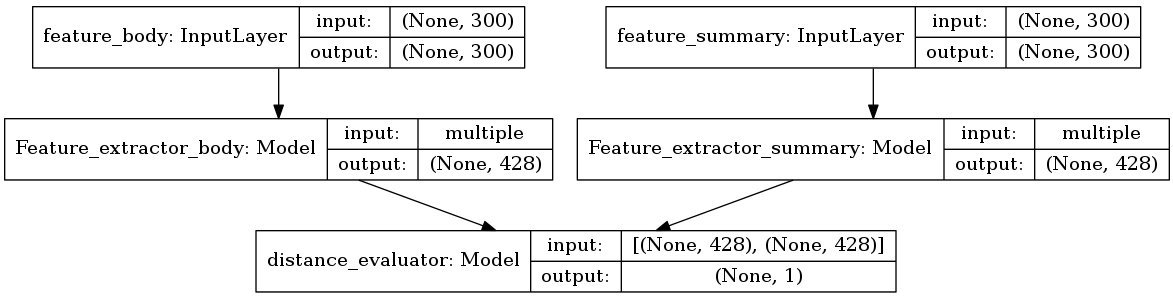

In [13]:
Image(decoded_file)

# In more details

Fontconfig warning: ignoring C.UTF-8: not a valid language tag



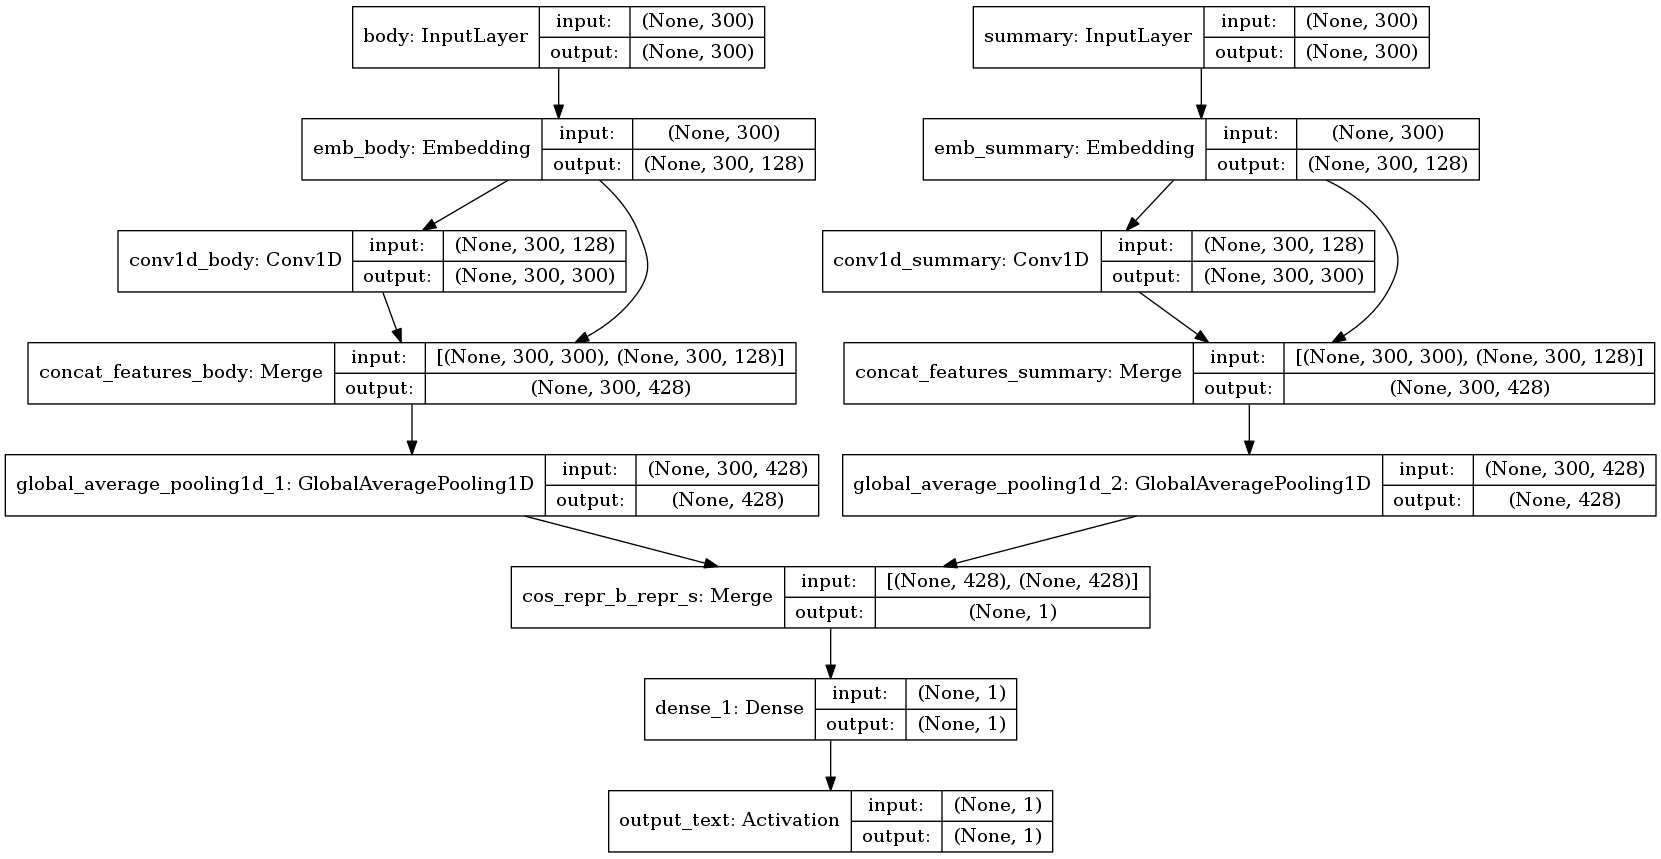

In [14]:
visu_model(model)

In [15]:
model.load_weights('/data_dump/model_language_weights.h5')

In [16]:
def get_itemsdb():
    """Utility function to retrieve the collection of models

    Returns:
        the collection of models"""
    client = MongoClient(_host_adress, _host_port)
    items = client[_db_name]
    return items[_items_collection]

def get_photosdb():
    """Utility function to retrieve the collection of models

    Returns:
        the collection of models"""
    client = MongoClient(_host_adress_p, _host_port)
    photos = client[_db_photos]
    return gridfs.GridFS(photos)

def sub_number(x):
    if x is not None:
        return regexp.sub('0', x)
    else:
        return None

def word_poper(seq, size_min=3):
    if seq is not None:
        seq = regexp_split.split(seq)
        for i, word in enumerate(seq):
            if len(word) < size_min:
                seq.pop(i)
        return ' '.join(seq)
    else:
        return None

def sequences_cuter(sequences, cut=300):
    new_sequences = []
    new_index_labels = []
    for j, sequence in enumerate(sequences):
        nb_divide = len(sequence) / cut
        for i in range(nb_divide):
            new_sequences.append(sequence[i * cut: (i + 1) * cut])
            new_index_labels.append(j)
        else:
            new_sequences.append(sequence)
            new_index_labels.append(j)
    return new_sequences, new_index_labels

def transform_text(text):
    text = sub_number(text)
    text = word_poper(text)
    return text

def load_tokenizer(path):
    with open(path, 'rb') as input_file:
        tokenizer = cPickle.load(input_file, encoding='utf8')
    return tokenizer


tokenizer_body = load_tokenizer('tokenizer_body.pkl')
tokenizer_summary = load_tokenizer('tokenizer_summary.pkl')

In [17]:
items_db = get_itemsdb()
photos_db = get_photosdb()

In [18]:
data_list = []
for i, item in enumerate(items_db.find()):
    if 'summary_multimedia_content_2' in item or 'summary_multimedia_content' in item:
        data_list.append(item)

In [19]:
indexes = np.arange(len(data_list))
np.random.shuffle(indexes)
indexes = indexes[:200000]
data = pd.DataFrame(data_list)
data = data.iloc[indexes]

In [20]:
data['body'] = data['body'].apply(sub_number)
data['body'] = data['body'].apply(word_poper)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:27: FutureWarning: split() requires a non-empty pattern match.


In [21]:
data['body_sequence'] = tokenizer_body.texts_to_sequences(data['body'])

In [22]:
data.columns

Index(['Unnamed: 0', '_id', 'author', 'body', 'custom_tags', 'date_pd', 'id',
       'id_gridfs_summary_multimedia_content',
       'id_gridfs_summary_multimedia_content_2', 'press_agency',
       'published_first_time', 'regions', 'slug', 'subjects', 'subthemes',
       'summary', 'summary_multimedia_content', 'summary_multimedia_content_2',
       'tags_from_filename', 'tags_from_filename_2', 'themeid', 'title',
       'body_sequence'],
      dtype='object')

In [23]:
def sequences_cuter(sequences, cut=300):
    new_sequences = []
    new_index_labels= []
    for j, sequence in enumerate(sequences):
        nb_divide = int(len(sequence) / cut)
        if nb_divide > 0:
            for i in range(nb_divide):
                new_sequences.append(sequence[i * cut: (i + 1) * cut])
                new_index_labels.append(j)
        else:
            new_sequences.append(sequence)
            new_index_labels.append(j)
    return new_sequences, new_index_labels

def get_features(item_keys, item, photos_db):
    all_items = []
    dict_output = dict()
    for key in item_keys:
        dict_output[key] = item[key]
    for key in item.keys():
        if 'gridfs'in key:
            to_check = item[key].dropna()
            if len(to_check) > 0:
                im_file = photos_db.find_one({'_id': to_check.iloc[0]})
                if im_file is not None:
                    im = pickle.loads(im_file.read())
                    dict_output['image_{}'.format(key)] = im
                    all_items.append(dict_output)
    return all_items



In [24]:
sequences, index = sequences_cuter(data['body_sequence'])

In [25]:
index = np.array(index)

In [26]:
sequences = pad_sequences(sequences, maxlen=300)

In [27]:
sequences

array([[   33,   525,  3749, ...,  2003,  2031, 15548],
       [ 3520, 26126,     8, ...,  2692,  7664,  1327],
       [  315,   214,  2400, ...,  1307,  1023,   397],
       ..., 
       [    0,     0,     0, ..., 21099,  4020,  9748],
       [    0,     0,     0, ...,    14,  5678, 12572],
       [    0,     0,     0, ...,  1320,  1832,  5608]], dtype=int32)

In [28]:
len(sequences)

206242

In [41]:
%%time
text = """
L'ambassadrice américaine auprès des Nations unies, Nikki Haley, a menacé vendredi d'une nouvelle action militaire américaine en Syrie, au lendemain du bombardement du régime syrien par Washington en représailles d'une attaque chimique imputée à Damas."""
text = transform_text(text)
text = tokenizer_summary.texts_to_sequences([text])
text = pad_sequences(text, maxlen=300)
text = np.tile(text, 20000).reshape(-1, 300)


CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 11.7 ms


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:27: FutureWarning: split() requires a non-empty pattern match.


In [45]:
%%time
predictions = model.predict([sequences[:20000], text], batch_size=128)
sorted_index = np.argsort(predictions, axis=0)[::-1]
cut_predictions = predictions[sorted_index[:70]]
cut_index = index[sorted_index[:70]]


CPU times: user 1.7 s, sys: 160 ms, total: 1.86 s
Wall time: 1.32 s


In [109]:
import numpy.ma as ma
import matplotlib.cm as cm

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    im_shape = imgs.shape
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border,
                           3),
                            dtype=np.float32)
    mosaic = np.empty((nrows * imshape[0] + (nrows - 1) * border,
                        ncols * imshape[1] + (ncols - 1) * border,
                       3),
                        dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in np.arange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [97]:
all_images = []
already_seen = []
for i in cut_index:
    if i not in already_seen:
        print(i)
        already_seen.append(i)
        data_point = data.iloc[i]
        for el in get_features(['title'], data_point, photos_db):
            printed_image = False
            for k in el:
                if 'image' in k and printed_image is False:
                    printed_image = True
                    all_images.append(el[k])
#                     plt.imshow(el[k])
#                     plt.show()
                elif 'image' not in k:
                    print(list(el[k]))
            break
        if len(all_images) > 53:
            break
        

[415]
['Crise syrienne : les divisions entre les rebelles éclatent au grand jour']
[16031]
["L'opposition syrienne condamne les exécutions rapportées par HRW"]
[3614]
["Syrie : l'État islamique détruit la prison de Palmyre"]
[10791]
['La France livrera 3 milliards&nbsp;$ d’armes au Liban grâce à des fonds saoudiens']
[9184]
["Des attentats revendiqués par l'EI font au moins 145&nbsp;morts sur la côte syrienne"]
[15807]
['Syrie : un attentat dans un marché bondé fait deux morts et plusieurs blessés']
[14221]
['Exode de Kurdes syriens face aux djihadistes']
[2072]
['Les manifestants syriens réclament la protection de la communauté internationale']
[18649]
['Syrie : 57 morts dans des villages abritant des déserteurs']
[18426]
["Les Amis du peuple syrien appellent l'ONU à durcir le ton"]
[5101]
['Syrie : Homs visée par le plus violent bombardement depuis cinq jours']
[6]
["La Syrie libère 61 femmes dans un accord d'échange de prisonniers"]
[11246]
["Syrie : Washington coordonnerait la four

In [104]:
all_images = np.array(all_images)

In [105]:
all_images.shape

(54, 300, 300, 3)

In [112]:
mosaic = make_mosaic(np.array(all_images[:36]), 6, 6)

In [114]:
mosaic.shape

(1805, 1805, 3)

L'ambassadrice américaine auprès des Nations unies, Nikki Haley, a menacé vendredi d'une nouvelle action militaire américaine en Syrie, au lendemain du bombardement du régime syrien par Washington en représailles d'une attaque chimique imputée à Damas.

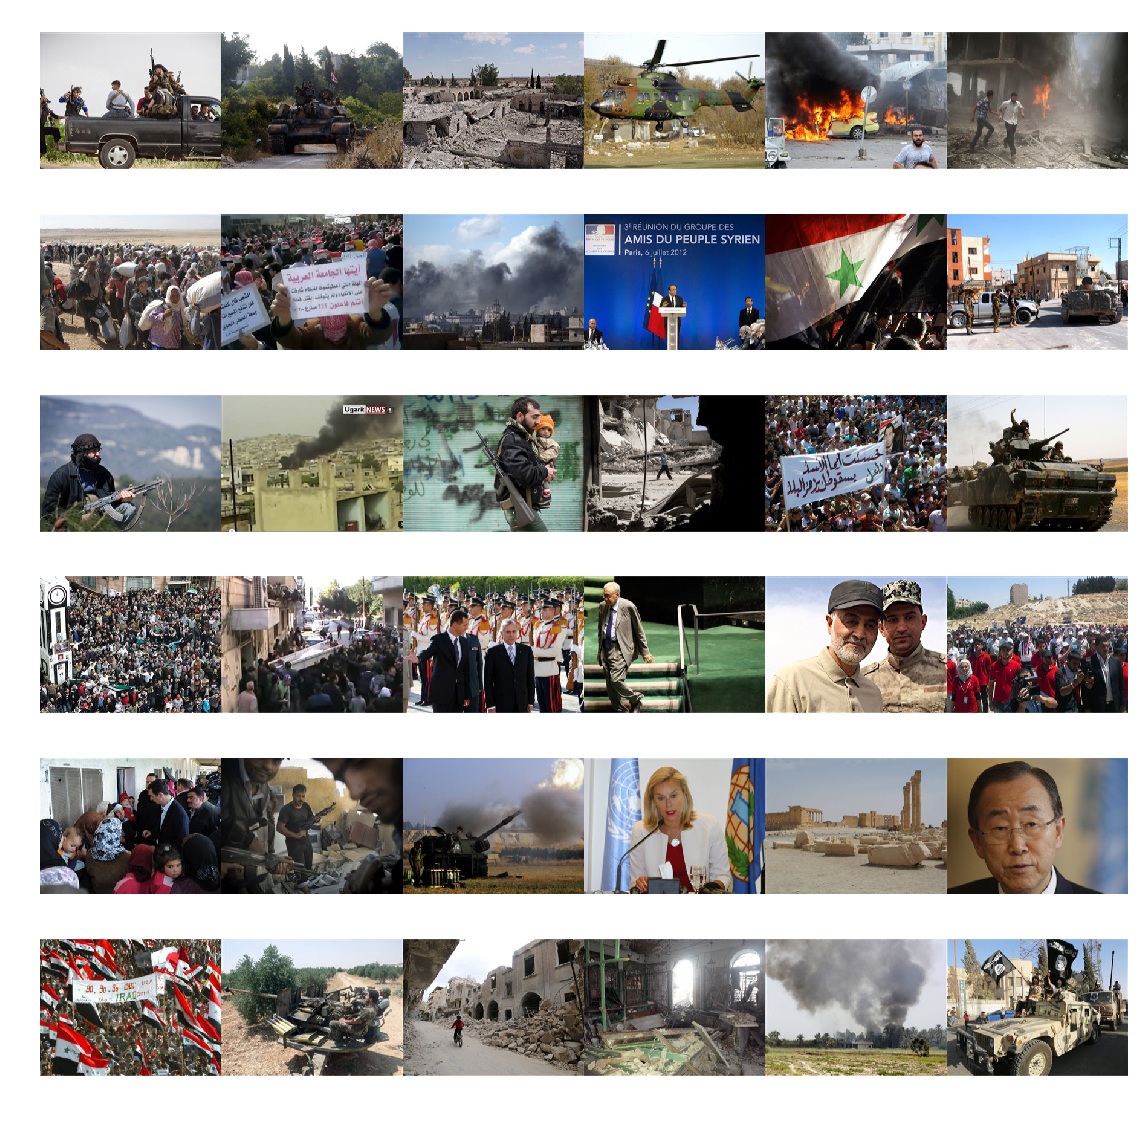

In [118]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(make_mosaic(np.array(all_images[:36]), 6, 6, border=0)/ 255.)
plt.show()